# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
print(os.getcwd())
os.chdir(r'C:\Users\Bazinga\AAIC\Assignments\AmazonDBSqlite')

C:\Users\Bazinga\AAIC\Assignments\NaiveBayes


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3  """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have removed in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:20<00:00, 2594.31it/s]


In [24]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## preprocessing for review summary.
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:45<00:00, 3440.23it/s]


In [26]:
#Combining preprocessed review text and preprocessed summary text
preprocessed_combinedText=[]
for i in range(0, len(preprocessed_reviews)):
    preprocessed_combinedText.append(preprocessed_reviews[i]+ ' ' + preprocessed_summary[i])
    

In [27]:
print(preprocessed_reviews[1500])
print('-----------------------------------')
print(preprocessed_summary[1500])
print('-----------------------------------')
print(preprocessed_combinedText[1500])

great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better
-----------------------------------
would best canola oil left
-----------------------------------
great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better would best canola oil left


In [28]:
print(len(preprocessed_reviews))
print(len(preprocessed_summary))
print(len(preprocessed_combinedText))

364171
364171
364171


In [29]:
final['CleanedText']=preprocessed_combinedText
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [30]:
final['CleanedText'].shape

(364171,)

In [31]:
final['Text'].shape

(364171,)

In [32]:
#Sorting based on Time
final['Time'] = pd.to_datetime(final['Time'], origin='unix', unit='s')
final = final.sort_values('Time')
print(final.shape)
print(final['Time'].head(1000))

(364171, 11)
138706   1999-10-08
138683   1999-10-25
417839   1999-12-02
346055   1999-12-06
417838   2000-01-03
            ...    
242710   2005-07-27
314365   2005-07-27
270097   2005-07-28
198583   2005-07-28
209305   2005-07-28
Name: Time, Length: 1000, dtype: datetime64[ns]


In [33]:
#Splitting Data into Train CV and Test
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(final['CleanedText'], final['Score'], test_size=.30, random_state=64)

In [34]:
print([i.shape for i in [X_train,X_test, Y_train, Y_test]])

[(254919,), (109252,), (254919,), (109252,)]


In [ ]:
sns.barplot(x=['Positive','Negative'], y=df['Score'].value_counts().values)
plt.show()

print(df['Score'].value_counts())

In [ ]:
final_value_counts=final['Score'].value_counts()
positiveClassPercentage=((final_value_counts.sum() - final_value_counts[0])/final_value_counts.sum())*100
negativeClassPercentage=100-positiveClassPercentage
print('Percentage of Positive reviews- {} %'.format(round(positiveClassPercentage, 2)))
print('Percentage of Negative reviews- {} %'.format(round(negativeClassPercentage, 2)))

# [4] Featurization

## [4.1] BAG OF WORDS

In [35]:
#Compute BoW
countVector=CountVectorizer(min_df=5)
bow_train=countVector.fit_transform(X_train)

bow_test=countVector.transform(X_test)

print(list(map(type, [bow_train,bow_test])))
print('Shape of bow_train is: ', bow_train.shape)
print('Shape of bow_test is: ', bow_test.shape)


[<class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>]
Shape of bow_train is:  (254919, 28115)
Shape of bow_test is:  (109252, 28115)


## [4.3] TF-IDF

In [36]:
#Compute tfidf
tfidfVector = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tfidf_train=tfidfVector.fit_transform(X_train)
tfidf_test=tfidfVector.transform(X_test)


print(list(map(type, [tfidf_train,tfidf_test])))
print('Shape of bow_train is: ', tfidf_train.shape)
print('Shape of bow_test is: ', tfidf_test.shape)


[<class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>]
Shape of bow_train is:  (254919, 323281)
Shape of bow_test is:  (109252, 323281)


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakage, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

In [3]:
import math
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

def naiveBayesGridSearchcv(trainData, trainLabels):
    #hyparameter alpha values
    alpha=dict(alpha=[pow(10, i) for i in range(-5, 3)])
    
    #using MultinomialNB as model
    multinomialNB=MultinomialNB(fit_prior=False, class_prior = [0.5, 0.5])
    
    #Using GridSearchCV to find best Hyperparameter alpha
    clf=GridSearchCV(estimator=multinomialNB, param_grid=alpha, scoring= 'roc_auc',
                     n_jobs=-1, cv=5, verbose=1, return_train_score=True)
    clf.fit(trainData, trainLabels)
    
    optimum_alpha=clf.best_params_['alpha']
    df=pd.DataFrame(clf.cv_results_)[['param_alpha', 'mean_test_score', 'mean_train_score']]
    log_alpha=[math.log(x) for x in df['param_alpha']]
    print(df)
    print('\nOptimum Alpha value is: ', optimum_alpha)

    #plotting Performance of AUC again various alpha values
    plt.close()
    plt.plot(log_alpha, df['mean_test_score'],'r-', label = 'Validation AUC')
    plt.plot(log_alpha, df['mean_train_score'],'b-', label = 'Train AUC')
    plt.xlabel('log(alpha)')
    plt.ylabel('AUC')
    plt.legend(loc='lower left')
    plt.title("Performance Model on Hyperparameter Alpha")
    plt.show()
    
    return optimum_alpha

In [2]:
def multinomailNBModel(trainData, trainLabels, testData, testLabels, optimum_alpha):
    optimum_alpha_value=1
    global mnb_clf
    mnb_clf=MultinomialNB(alpha=optimum_alpha_value, fit_prior=False, class_prior = [0.5, 0.5]) 
    mnb_clf.fit(trainData, trainLabels)

    test_probs=mnb_clf.predict_log_proba(testData)[:, 1]
    test_fpr, test_tpr, test_thresholds = roc_curve(testLabels, test_probs)

    train_probs=mnb_clf.predict_log_proba(trainData)[:, 1]
    train_fpr, train_tpr, train_thresholds = roc_curve(trainLabels, train_probs)

    print('\nAUC score of the Optimum model is: ', round(roc_auc_score(testLabels, test_probs), 5))

    #plot ROC AUC Curve
    plt.plot(train_fpr, train_tpr, linestyle='--', label='Train ROC')
    plt.plot(test_fpr, test_tpr, 'r-', label='Test ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    #Plot Confusion Matrix
    confusion_mat=confusion_matrix(testLabels, mnb_clf.predict(testData))
    df_confusion_matrix=pd.DataFrame(confusion_mat, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
    sns.heatmap(df_confusion_matrix, annot=True, fmt="d")
    plt.title("ROC AUC Curve")
    plt.title("Confusiion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.legend('right bottom')
    plt.show()

In [39]:
#get positve and negative important features
def getImportantFeatures(count_vector, clf, classLabel):
    
    logProbs=clf.feature_log_prob_[classLabel]
    zipped_values=list(zip(count_vector.get_feature_names(), logProbs))
    sorted_values=sorted(zipped_values, key=lambda x: x[1], reverse=True)
    
    return sorted_values

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

Fitting 5 folds for each of 8 candidates, totalling 40 fits
  param_alpha  mean_test_score  mean_train_score
0     0.00001         0.914898          0.965131
1      0.0001         0.923307          0.964754
2       0.001         0.931861          0.964185
3        0.01         0.939833          0.963263
4         0.1         0.945922          0.961649
5           1         0.948334          0.958220
6          10         0.936158          0.942612
7         100         0.732595          0.735705

Optimum Alpha value is:  1


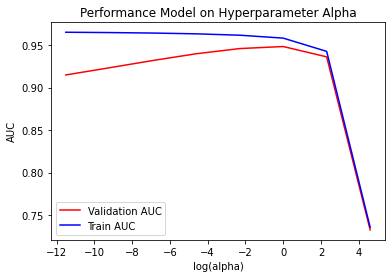

In [41]:
#Find best hyperparameter alpha on BagOfWords representation of vectors
#Find Validation AUC and Train AUC
#plot Performance Model on Hyperparameter Alpha

bowOptimalAlpha=naiveBayesGridSearchcv(bow_train, Y_train)



AUC score of the Optimum model is:  0.9471


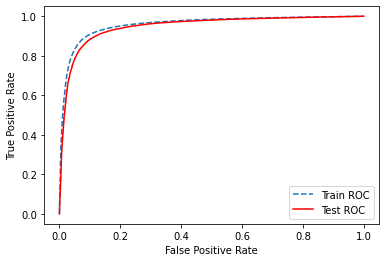

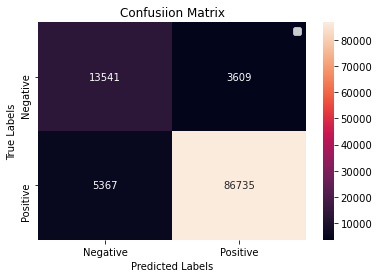

In [42]:
#fit model on best hyperparameter alpha
#find AUC score on test data
#plot ROC AUC curve
#plot confusion matrix

multinomailNBModel(bow_train, Y_train, bow_test, Y_test, bowOptimalAlpha)

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [43]:
#Top 10 important features of positive class with BOW represntaion of vectors
topPositiveFeatures=getImportantFeatures(countVector, mnb_clf, 1)[:10]
df=pd.DataFrame(data=topPositiveFeatures, columns=['Top Positive Features', 'Log Probalities'])
df.index = np.arange(1, len(df) + 1)
df

,Top Positive Features,Log Probalities
1,not,-3.750680
2,great,-4.434199
3,good,-4.506705
4,like,-4.577865
5,taste,-4.926139
6,one,-4.927643
7,love,-4.931411
8,tea,-4.973137
9,product,-4.984269
10,coffee,-4.987775


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [44]:
#Top 10 important features of negative class with BOW represntaion of vectors
topNegativeFeatures=getImportantFeatures(countVector, mnb_clf, 0)[:10]
df=pd.DataFrame(data=topNegativeFeatures, columns=['Top Negative Features', 'Log Probalities'])
df.index = np.arange(1, len(df) + 1)
df

,Top Negative Features,Log Probalities
1,not,-3.201258
2,like,-4.389275
3,product,-4.642282
4,taste,-4.644675
5,would,-4.712206
6,one,-4.905905
7,good,-5.031774
8,no,-5.099532
9,flavor,-5.132888
10,coffee,-5.143914


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

Fitting 5 folds for each of 8 candidates, totalling 40 fits
  param_alpha  mean_test_score  mean_train_score
0     0.00001         0.924369          0.998696
1      0.0001         0.938361          0.998481
2       0.001         0.953212          0.998042
3        0.01         0.966279          0.996975
4         0.1         0.972170          0.993732
5           1         0.963369          0.981355
6          10         0.839636          0.854203
7         100         0.740769          0.745734

Optimum Alpha value is:  0.1


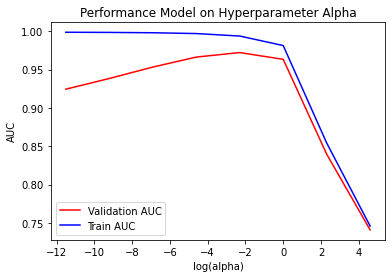

In [45]:
#Find best hyperparameter alpha on tfidf representation of vectors
#Find Validation AUC and Train AUC
#plot Performance Model on Hyperparameter Alpha
tfidfOptimalAlpha = naiveBayesGridSearchcv(tfidf_train, Y_train)


AUC score of the Optimum model is:  0.96617


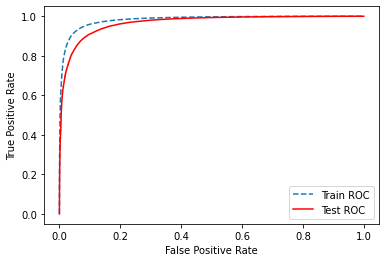

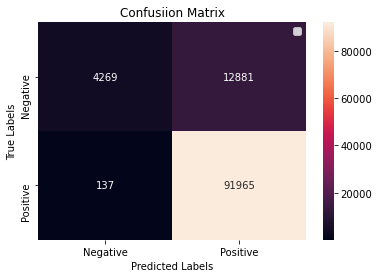

In [46]:
#fit model on best hyperparameter alpha
#find AUC score on test data
#plot ROC AUC curve
#plot confusion matrix

multinomailNBModel(tfidf_train, Y_train, tfidf_test, Y_test, tfidfOptimalAlpha)


### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [47]:
#Top 10 important features of positive class with BOW represntaion of vectors
topPositiveFeatures=getImportantFeatures(tfidfVector, mnb_clf, 1)[:10]
df=pd.DataFrame(data=topPositiveFeatures, columns=['Top Positive Features', 'Log Probalities'])
df.index = np.arange(1, len(df) + 1)
df

,Top Positive Features,Log Probalities
1,not,-5.894051
2,great,-6.002651
3,good,-6.149553
4,tea,-6.289277
5,coffee,-6.297203
6,love,-6.349084
7,like,-6.366360
8,product,-6.473728
9,taste,-6.540275
10,best,-6.544624


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [48]:
#Top 10 important features of negative class with BOW represntaion of vectors
topNegativeFeatures=getImportantFeatures(tfidfVector, mnb_clf, 0)[:10]
df=pd.DataFrame(data=topNegativeFeatures, columns=['Top Negative Features', 'Log Probalities'])
df.index = np.arange(1, len(df) + 1)
df

,Top Negative Features,Log Probalities
1,not,-5.781324
2,like,-6.669279
3,taste,-6.762738
4,product,-6.774169
5,would,-6.857546
6,coffee,-7.048884
7,one,-7.117209
8,no,-7.145668
9,flavor,-7.203012
10,good,-7.281053


In [4]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Best hyperparameter(alpha)", "Test AUC Score"]
x.add_row(["BOW", bowOptimalAlpha, 0.9471])
x.add_row(["TFIDF", tfidfOptimalAlpha, 0.96617])
x.add_row(["AVG_W2V", bowOptimalAlpha, 0.9471])
x.add_row(["TFIDF_W2V", tfidfOptimalAlpha, 0.96617])
print(x)

NameError: name 'bowOptimalAlpha' is not defined

# [6] Conclusions

- Naive Bayes model is built on entire dataset with 568,454 reviews
- The Feature Engineering technique of adding Review and Summary texts worked really good
- Naive Bayes worked pretty well with TFIDF vectorizer yielding AUC score of 96.6%
- It also performed good on BOW vectorizer with AUC score 94.7%